## NorthernTracks time sampling benchmark
This notebooks illustrate briefly the simulation of Monte Carlo times to build the IceCube NothernTracks background data. While IceCube PSTracks selection uses scrambled data as background, NorthernTracks uses a Monte Carlo simulation. The MC event times are not meaningful and need to be simulated in flarestack according to the so-called "detector on off list" (background events needs to be uniformly distributed in the taking periods represented in the "Good Run List"). Under no circumstance should events "leak" in the detector off periods.

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(level=logging.WARNING)

In [3]:
from flarestack.data.dataset_index import dataset_index

In [4]:
# Load the dataset.
data = dataset_index.get_dataset("icecube.northern_tracks_v005_p01")
# Dataset has a single season, let's extract it.
season = data['IC86_1-11']
# Get the time pdf of the season.
T = season.get_time_pdf()
# Check that the numbers make sense.
duration_days = T.t1 - T.t0
livetime_days = T.get_livetime()
uptime_fraction = livetime_days / duration_days
print(f"Season spans between {T.t0:.02f} and {T.t1:.02f} MJD and has a livetime of {T.get_livetime():.02f} days. Uptime fraction is {uptime_fraction:.03f}.")

Season spans between 55694.42 and 59623.51 MJD and has a livetime of 3804.09 days. Uptime fraction is 0.968.


In [5]:
# Load Monte Carlo data
season.load_background_model()

In [6]:
# Simulate a realistic number of events.
# In NTv5, 'weight' is overwritten by flarestack as to represent a number of events.
# A sum over 'weight' will give you the total number of (expected) events in the season.
n_ev = int(np.sum(season.loaded_background_model['weight']))
rate_mHz = 1000* n_ev / (86400 * livetime_days)
# In a real simulation, we would need to apply a Poisson fluctuation to n_ev.

In [7]:
# Simulate times and sort them for convenience.
# Rate should be in the few mHz range for most track selections.
print(f"Generating {n_ev} events. Rate is {rate_mHz:.1f} mHz.")
times = np.sort(T.simulate_times(source=None, n_s=n_ev))

Generating 791776 events. Rate is 2.4 mHz.


We want now to check that no event fall in the "off" region, so let's use the PDF.

In [8]:
# Sum the PDF values over all the times.
# The PDF should always evaluate to 1 so this sum should give the number of events.
valid_times = np.sum(T.season_f(times))

print(f"Valid times {valid_times} / {len(times)}.")

Valid times 791776.0 / 791776.


Now we want to check visually that the events are distributed as expected. For this we should look at the transitions between on and off periods.

In [9]:
def find_gaps(time_pdf, min_width_days = 0.25):
    """
    Finds gaps in "time_pdf" where the function is zero for a given time frame.
    In other words, find the "off" periods of the detector given a minimum width.
    """
    t1, t0 = time_pdf.t1, time_pdf.t0 # start and end of season
    f = time_pdf.season_f # time pdf
    n_s = int((t1 - t0) * 24 * 60 * 2) # we sample the function with two samples per minute
    t = np.linspace(t0, t1, 1 + n_s)
    dt = (t1-t0) / n_s # time difference between two samples
    min_sep = min_width_days / dt # separation in samples to give a gap of min_width_days
    i_live = (f(t) != 0).nonzero()[0] # indices of t values where the function is "live" (non-zero)
    d_live = i_live[1:]-i_live[:-1] # distance in index space between any consecutive "live" regions
    # d_live[i] = N; for N=1 there is no gap, otherwise there is a gap of N-1 samples
    # now look up the mjd times where the gaps occurs
    gaps = []
    for i in np.arange(len(d_live)):
        # loop over the distances
        if d_live[i] > min_sep:
            # i is the index in the distance array
            # from this we look up the index in the time array
            i_gap = i_live[i]
            gaps.append(t[i_gap])
    return gaps

In [10]:
gaps_mjd = find_gaps(T)

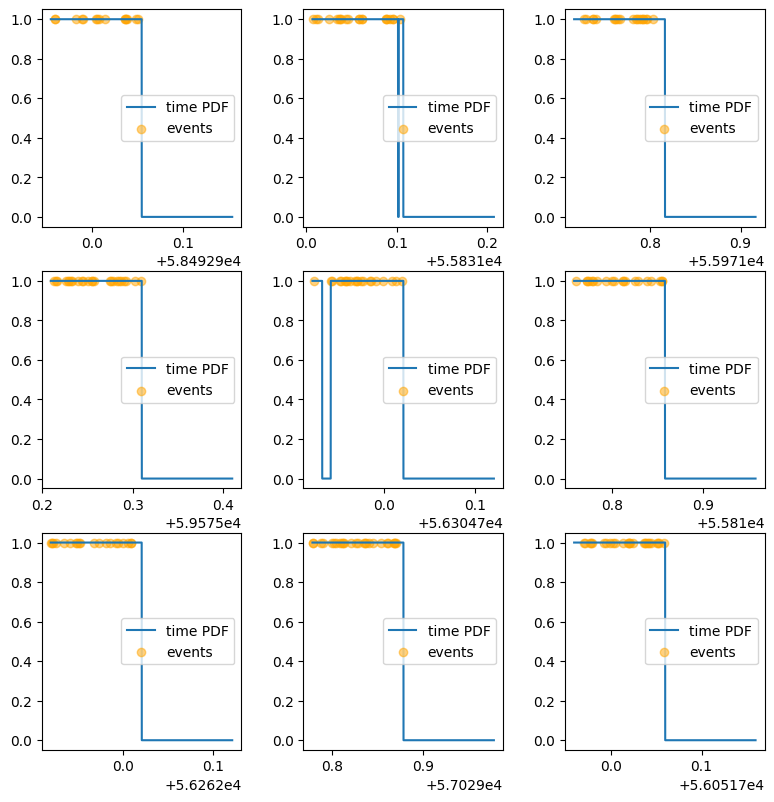

In [11]:
# We sample n_gaps from the gaps we have found and we make a visual check.
n_gaps = 9

fig, axs = plt.subplots(3,3, figsize=(8,8))
fig.tight_layout()

gap_sample = np.random.choice(gaps_mjd, n_gaps)

for i, mjd in enumerate(gap_sample):
    row, col = i // 3, i % 3
    ax = axs[row, col]
    t0, t1 = mjd - 0.1, mjd + 0.1
    timebase = np.linspace(t0, t1, 1 + 2 * 86400)
    ax.plot(timebase, T.season_f(timebase), label="time PDF")
    selected_times = times[(times > t0) & (times < t1)]
    ax.scatter(selected_times, np.ones_like(selected_times), color='orange', alpha=0.5, label="events")
    ax.legend()
    ax.set_label("Time [mjd]")